In [25]:
import os
import sqlite3
import numpy as np
data_dir = os.path.join("/", "data", "takagi", "globefish")
dbname = os.path.join(data_dir, "peopleflow.sqlite")
con = sqlite3.connect(dbname)
cur = con.cursor()

In [26]:
from functools import reduce
from operator import add
import random
import src.map_processor as map_processor
import matplotlib.pyplot as plt

for x in cur.execute("select min(Latitude), max(Latitude) from peopleflow6"):
    min_lat, max_lat = x
for x in cur.execute("select min(Longitude), max(Longitude) from peopleflow6"):
    min_lon, max_lon = x
    
mp = map_processor.Map(1000, min_lon, max_lon, min_lat, max_lat)

locations = {}
n_uids = 11537
uids = range(n_uids)
for id in uids:
    locations_id = []
    for x in cur.execute(f"select Longitude, Latitude, placeID, attr1, attr2 from peopleflow6 where uid={id}"):
        if x[2] in ["2", "3", "4", "5", "6", "7"]:
            locations_id.append([float(x[0]), float(x[1])])
    locations[id] = np.array(locations_id)
    
data = []
data_one_hot = []
for latlons in locations.values():
    if len(latlons) != 0:
        states = set(mp.find_nearest_states(latlons))
        data_one_hot.append(set([random.choice(list(states))]))
        data.append(states)

possible_states_with_time = reduce(set.union, data_one_hot)
possible_states = reduce(set.union, data)
possible_coords_with_time = mp.states_to_coords(possible_states_with_time)
possible_coords = mp.states_to_coords(possible_states)

In [38]:
def plot(states, s=5):
    coords = mp.states_to_coords(states)
    plt.scatter(coords[:, 0], coords[:, 1], s=s)
    plt.show()
    
def plot_two(states, states2, s=5, filename="temp.png"):
    coords = mp.states_to_coords(states)
    coords2 = mp.states_to_coords(states2)
    plt.scatter(coords[:, 0], coords[:, 1], s=s, label="safe spot")
    plt.scatter(coords2[:, 0], coords2[:, 1], s=s, label="hot spot")
    plt.legend(fontsize=12)
    plt.tick_params(labelbottom=False,
                   labelleft=False,
                   labelright=False,
                   labeltop=False)
    plt.tick_params(bottom=False,
                   left=False,
                   right=False,
                   top=False)
    plt.savefig(os.path.join("imgs", filename), bbox_inches="tight")
    plt.show()
    
def get_counts(data):
    reduced_data = [state for states in data for state in states]
    counts = []
    for state in possible_states:
        if not state in dict(counts):
            count = reduced_data.count(state)
            counts.append((state,count))
        else:
            counts.append((state,0))
    return dict(counts)

def get_perturbed_counts(data, possible_states, epsilon=1):
    counts = get_counts(data)
    perturbed_counts = {}
    for state in possible_states:
        noise = np.random.exponential(1/epsilon)
        perturbed_counts[state] = dict(counts)[state] + noise
    return perturbed_counts

def get_perturbed_counts_from_counts(counts, epsilon=1):
    perturbed_counts = {}
    for key, value in counts.items():
        noise = np.random.exponential(1/epsilon)
        perturbed_counts[key] = noise + value
    return perturbed_counts

def get_hot_states(counts, threshold=5):
    return [key for key, value in counts.items() if value >= threshold]

def get_error(counts, perturbed_counts, threshold=5):
    univ = 0
    error = 0
    for key, value in counts.items():
        if value < threshold:
            univ += 1
            if not (perturbed_counts[key] <= threshold):
                error += 1
    return error/univ

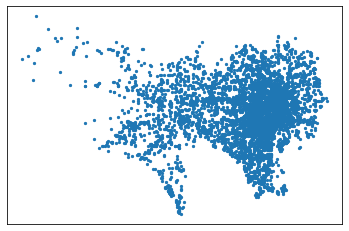

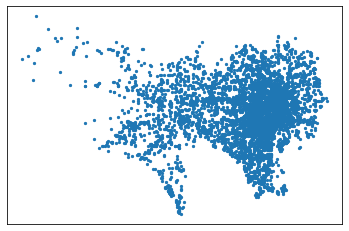

0.0013757523645743766


In [39]:
np.random.seed(0)
n = 2000
i = 0
threshold = 10
epsilon = 1
counts = get_counts(data_one_hot[i*n:(i+1)*n])
perturbed_counts = get_perturbed_counts(data_one_hot[i*n:(i+1)*n], possible_states, epsilon=epsilon)

hot_states = get_hot_states(counts, threshold=threshold)
perturbed_hot_states = get_hot_states(perturbed_counts, threshold=threshold)

plot_two(possible_states, hot_states, filename="ground_truth.png")
plot_two(possible_states, perturbed_hot_states, filename="epsilon1.png")
error = get_error(counts, perturbed_counts, threshold=threshold)
print(error)

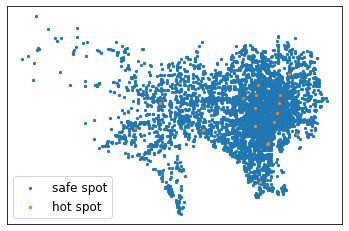

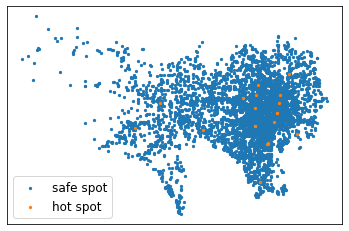

0.00017196904557179707


In [29]:
np.random.seed(0)
n = 2000
i = 0
threshold = 10
epsilon = 2
counts = get_counts(data_one_hot[i*n:(i+1)*n])
perturbed_counts = get_perturbed_counts(data_one_hot[i*n:(i+1)*n], possible_states, epsilon=epsilon)

hot_states = get_hot_states(counts, threshold=threshold)
perturbed_hot_states = get_hot_states(perturbed_counts, threshold=threshold)

plot_two(possible_states, hot_states)
plot_two(possible_states, perturbed_hot_states, filename="epsilon2.png")
error = get_error(counts, perturbed_counts, threshold=threshold)
print(error)

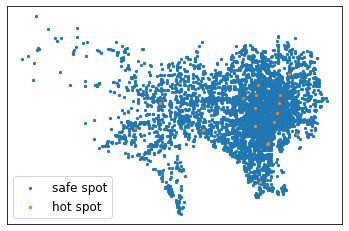

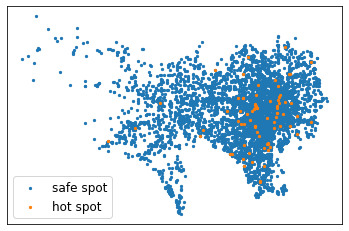

0.009630266552020636


In [30]:
np.random.seed(0)
n = 2000
i = 0
threshold = 10
epsilon = 0.5
counts = get_counts(data_one_hot[i*n:(i+1)*n])
perturbed_counts = get_perturbed_counts(data_one_hot[i*n:(i+1)*n], possible_states, epsilon=0.5)

hot_states = get_hot_states(counts, threshold=threshold)
perturbed_hot_states = get_hot_states(perturbed_counts, threshold=threshold)

plot_two(possible_states, hot_states)
plot_two(possible_states, perturbed_hot_states, filename="epsilon05.png")
error = get_error(counts, perturbed_counts, threshold=threshold)
print(error)

In [31]:
len(perturbed_hot_states)

76

In [32]:
def plot_bar(counts):
    counts_counts = {}
    counts_ = {}
    for key, value in counts.items():
        counts_[key] = int(value)
    for i in range(max(list(counts_.values())) + 1):
        counts_counts[i] = list(counts_.values()).count(i)
    plt.bar(counts_counts.keys(), counts_counts.values())
    plt.xticks(list(counts_counts.keys()), list(counts_counts.keys()),fontsize=15)
    plt.yticks(fontsize=15)

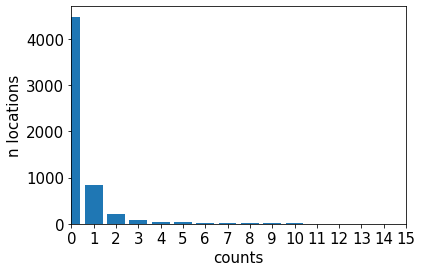

In [33]:
counts = get_counts(data[:500])
plot_bar(counts)
plt.xlim(0,15)
plt.xlabel("counts", fontsize=15)
plt.ylabel("n locations", fontsize=15)
plt.savefig("imgs/peopleflow.png", bbox_inches="tight")

In [23]:
len(counts)

5835

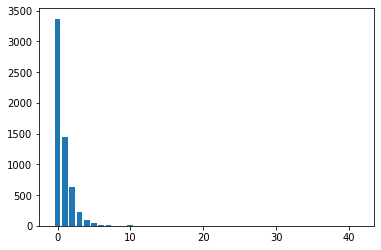

In [202]:
plot_bar(perturbed_counts)

In [346]:
n = 2000
x = list(map(int, np.random.exponential(1, n)))
counts = {}
for i in range(n):
    counts[i] = x[i]
    
perturbed_counts = get_perturbed_counts_from_counts(counts)
error = get_error(counts, perturbed_counts)

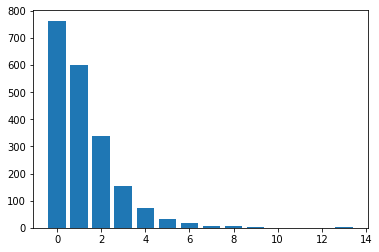

In [347]:
plot_bar(perturbed_counts)

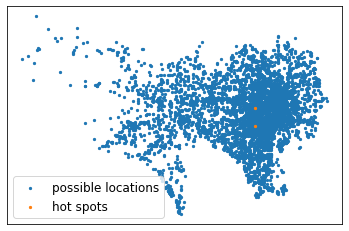

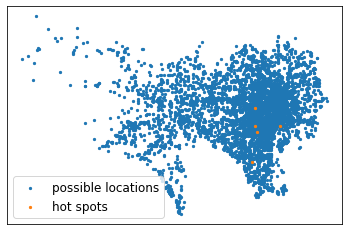

0.0005143151037202125


In [437]:
np.random.seed(0)
n = 500
i = 0
threshold = 10
counts = get_counts(data_one_hot[i*n:(i+1)*n])
perturbed_counts = get_perturbed_counts(data_one_hot[i*n:(i+1)*n], possible_states, epsilon=1)

hot_states = get_hot_states(counts, threshold=threshold)
perturbed_hot_states = get_hot_states(perturbed_counts, threshold=threshold)

plot_two(possible_states, hot_states, filename="ground_truth.png")
plot_two(possible_states, perturbed_hot_states, filename="epsilon1.png")
error = get_error(counts, perturbed_counts, threshold=threshold)
print(error)

In [498]:
hot_states = []
perturbed_hot_states = []
threshold = 10
n_iter = 5
epsilons = [0.5, 1, 2]

errors = {epsilon:[] for epsilon in epsilons}
number_of_hotspots = []

is_plot = False

for epsilon in epsilons:
    np.random.seed(0)
    perturbed_hot_states = []
    hot_states = []
    for i in range(n_iter):
        counts = get_counts(data_one_hot[:(i+1)*n])
        perturbed_counts = get_perturbed_counts(data_one_hot[:(i+1)*n], possible_states, epsilon=epsilon)

        hot_states.extend(get_hot_states(counts, threshold=threshold))
        perturbed_hot_states.extend(get_hot_states(perturbed_counts, threshold=threshold))

        hot_states = list(set(hot_states))
        perturbed_hot_states = list(set(perturbed_hot_states))

        if is_plot:
            plot_two(possible_states, hot_states, filename="ground_truth.png")
            plot_two(possible_states, perturbed_hot_states, filename=f"epsilon{epsilon}.png")
        error = get_error(counts, perturbed_counts, threshold=threshold)
        errors[epsilon].append(error)
        number_of_hotspots.append(len(hot_states))

In [499]:
errors

{0.5: [0.006686096348362764,
  0.008236101578586136,
  0.007556242486690709,
  0.009628610729023384,
  0.009122203098106713],
 1: [0.0005143151037202125,
  0.00034317089910775565,
  0.0001717327837884252,
  0.000343878954607978,
  0.0006884681583476765],
 2: [0.0, 0.0, 0.0, 0.0, 0.00017211703958691912]}

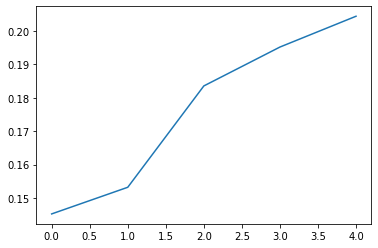

In [509]:
plt.plot(range(5), errors[0.5])

In [552]:
hot_states = []
perturbed_hot_states = []
threshold = 10
n_iter = 5
epsilons = [0.5, 1, 2]
n_shuffle = 20

errors = {epsilon:[0 for _ in range(n_iter)] for epsilon in epsilons}
number_of_hotspots = []

is_plot = False
np.random.seed(0)

for epsilon in epsilons:
    for _ in range(n_shuffle):
        random.shuffle(data_one_hot)
        perturbed_hot_states = []
        hot_states = []
        for i in range(n_iter):
            counts = get_counts(data_one_hot[:(i+1)*n])
            perturbed_counts = get_perturbed_counts(data_one_hot[:(i+1)*n], possible_states, epsilon=epsilon)

            hot_states.extend(get_hot_states(counts, threshold=threshold))
            perturbed_hot_states.extend(get_hot_states(perturbed_counts, threshold=threshold))

            hot_states = list(set(hot_states))
            perturbed_hot_states = list(set(perturbed_hot_states))

            if is_plot:
                plot_two(possible_states, hot_states, filename="ground_truth.png")
                plot_two(possible_states, perturbed_hot_states, filename=f"epsilon{epsilon}.png")
            error = get_error(counts, perturbed_counts, threshold=threshold)
            errors[epsilon][i] += error/n_shuffle
            number_of_hotspots.append(len(hot_states))

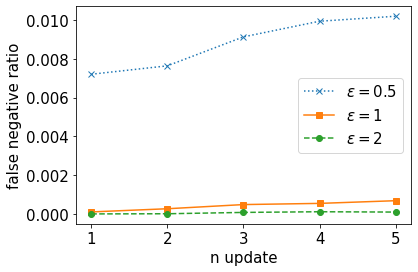

In [542]:
plt.plot(range(1,6), errors[0.5], label="$\epsilon=0.5$", linestyle="dotted", marker="x")
plt.plot(range(1,6), errors[1], label="$\epsilon=1$", marker="s")
plt.plot(range(1,6), errors[2], label="$\epsilon=2$", linestyle="dashed", marker="o")
plt.xlabel("n update", fontsize=15)
plt.ylabel("false negative ratio", fontsize=15)
plt.xticks(range(1,6), range(1,6),fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig("imgs/error.png", bbox_inches="tight")

In [553]:
hot_states = []
perturbed_hot_states = []
thresholds = [2,5,10,20]
n_iter = 5
epsilons = [0.5, 1, 2]

errors = {epsilon:[] for epsilon in epsilons}

is_plot = False
np.random.seed(0)

for threshold in thresholds:
    for epsilon in epsilons:
        perturbed_hot_states = []
        hot_states = []
        for i in range(n_iter):
            counts = get_counts(data_one_hot[:(i+1)*n])
            perturbed_counts = get_perturbed_counts(data_one_hot[:(i+1)*n], possible_states, epsilon=epsilon)

            hot_states.extend(get_hot_states(counts, threshold=threshold))
            perturbed_hot_states.extend(get_hot_states(perturbed_counts, threshold=threshold))

            hot_states = list(set(hot_states))
            perturbed_hot_states = list(set(perturbed_hot_states))

            if is_plot:
                plot_two(possible_states, hot_states, filename="ground_truth.png")
                plot_two(possible_states, perturbed_hot_states, filename=f"epsilon{epsilon}.png")
            error = get_error(counts, perturbed_counts, threshold=threshold)
        errors[epsilon].append(error)

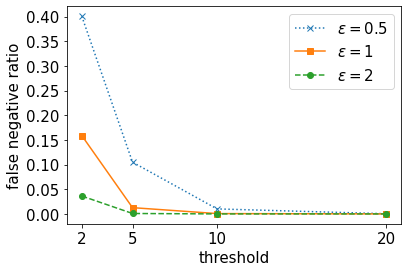

In [556]:
plt.plot(thresholds, errors[0.5], label="$\epsilon=0.5$", linestyle="dotted", marker="x")
plt.plot(thresholds, errors[1], label="$\epsilon=1$", marker="s")
plt.plot(thresholds, errors[2], label="$\epsilon=2$", linestyle="dashed", marker="o")
plt.xlabel("threshold", fontsize=15)
plt.ylabel("false negative ratio", fontsize=15)
plt.xticks(thresholds, thresholds,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig("imgs/threshold.png", bbox_inches="tight")

In [595]:
epsilon = 1
threshold = 5
f = lambda k, epsilon: 1/np.exp(k*epsilon)

In [599]:
def prob(threshold,epsilon):
    return range(threshold), [f(threshold-i, epsilon) for i in range(threshold)]

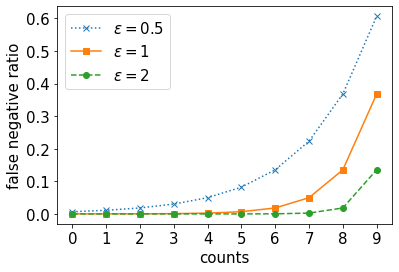

In [627]:
threshold=10
plt.plot(*prob(threshold,0.5), label="$\epsilon=0.5$", linestyle="dotted", marker="x")
plt.plot(*prob(threshold,1), label="$\epsilon=1$", marker="s")
plt.plot(*prob(threshold,2), label="$\epsilon=2$",  linestyle="dashed", marker="o")
plt.legend(fontsize=15)
plt.xticks(range(threshold), range(threshold),fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("counts", fontsize=15)
plt.ylabel("false negative ratio", fontsize=15)
plt.savefig("imgs/threshold10.png", bbox_inches="tight")

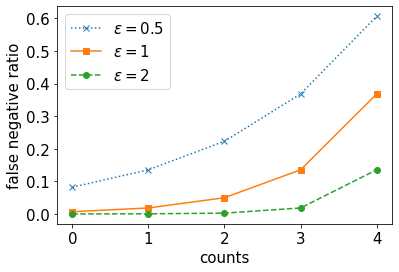

In [625]:
threshold = 5
plt.plot(*prob(threshold,0.5), label="$\epsilon=0.5$", linestyle="dotted", marker="x")
plt.plot(*prob(threshold,1), label="$\epsilon=1$", marker="s")
plt.plot(*prob(threshold,2), label="$\epsilon=2$",  linestyle="dashed", marker="o")
plt.legend(fontsize=15)
plt.xticks(range(threshold), range(threshold),fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("counts", fontsize=15)
plt.ylabel("false negative ratio", fontsize=15)
plt.savefig("imgs/threshold5.png", bbox_inches="tight")

In [624]:
len(possible_states)

5835

In [35]:
1-1-1/np.exp(1)

-0.36787944117144233